# Data Exploration of Water Level of the Rhine

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [41]:
data = pd.read_csv('data/Kaub_Level_Since_2013.csv')
path = 'results/' # Used for saving figures later on

In [42]:
data.head()

,date,level
0,2013-01-01,510
1,2013-01-02,461
2,2013-01-03,414
3,2013-01-04,378
4,2013-01-05,351


In [43]:
data.tail()

,date,level
3219,2021-10-23,117
3220,2021-10-24,105
3221,2021-10-25,93
3222,2021-10-26,85
3223,2021-10-27,82


In [44]:
data.describe()

,level
count,3224.000000
mean,206.495658
std,102.425145
min,20.000000
25%,139.000000
50%,187.000000
75%,253.000000
max,713.000000


In [45]:
data.median()

/tmp/ipykernel_42995/4184645713.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.median()


level    187.0
dtype: float64

The median is a little bit off the mean, with the mean > median, this suggests that there are more or stronger outliers in the maximum range. 

In [46]:
data.isna().any()

date     False
level    False
dtype: bool

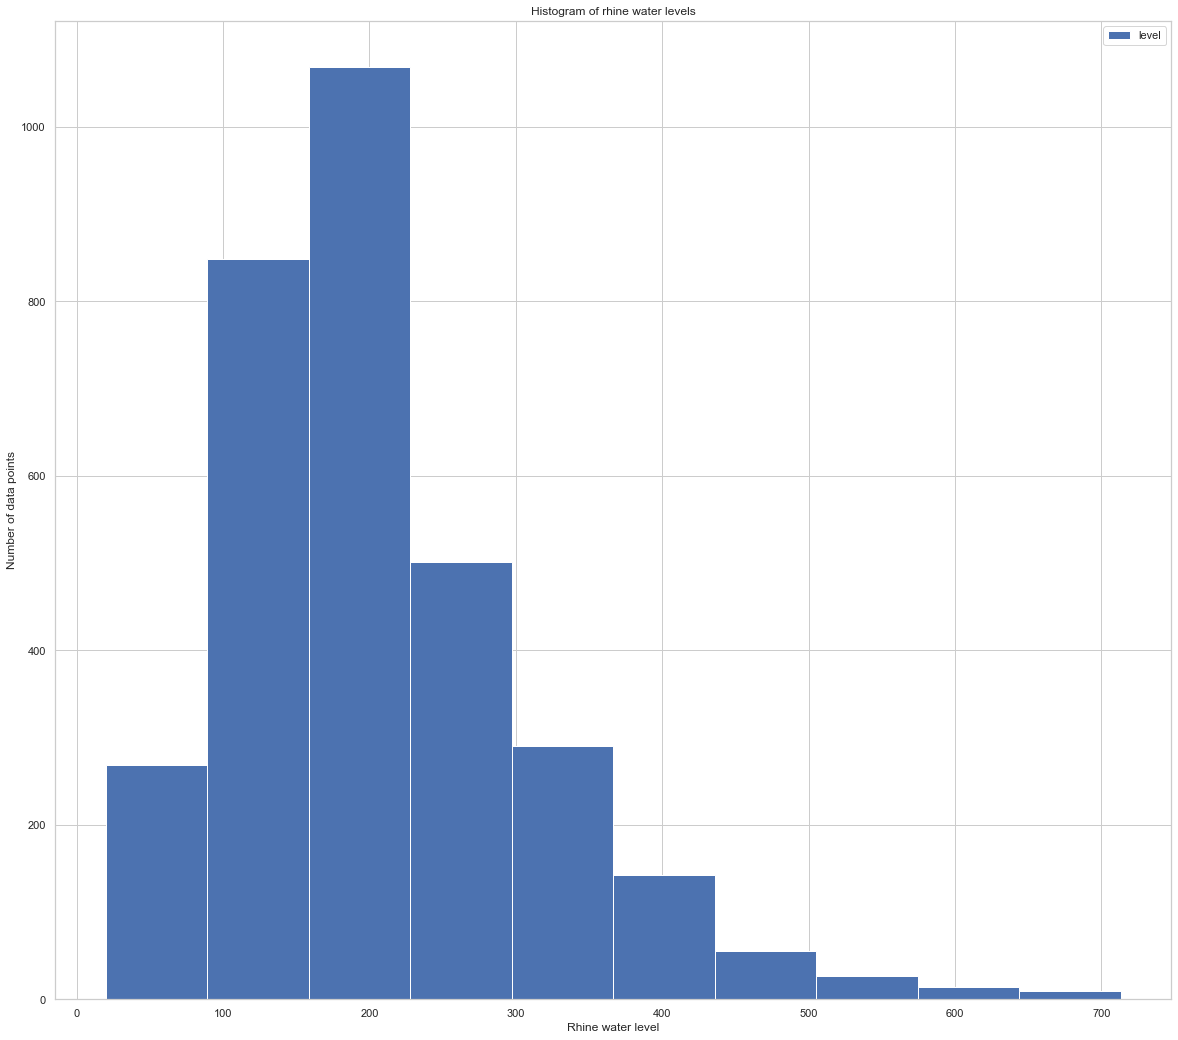

In [47]:
data.hist(legend='true')
plt.xlabel('Rhine water level')
plt.ylabel('Number of data points')
plt.title('Histogram of rhine water levels')
plt.savefig(path + 'histogramm.png', dpi=300)

In the following, I will show the data with linear regression used on it to see an approximate trend.

m is: -0.012579379122448421; b is: 226.76732702406383


<Figure size 1440x1296 with 0 Axes>

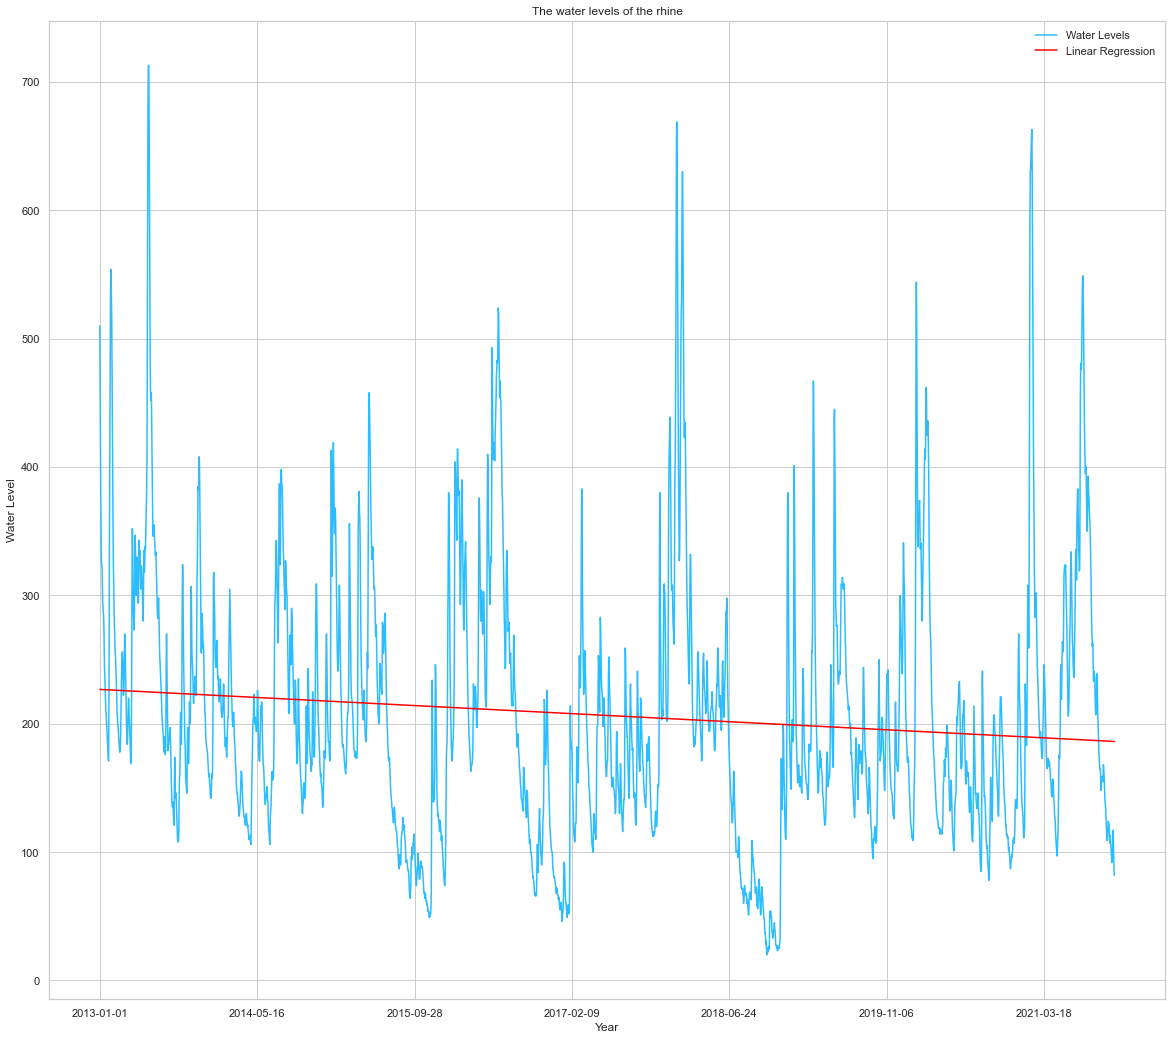

In [48]:
plt.figure(1)
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
color_list = [CB91_Blue, 'red']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
data.plot(x='date', y='level')
m, b = np.polyfit(np.arange(len(data.index)), data['level'], 1)
plt.plot(np.arange(len(data.index)), m * np.arange(len(data.index)) + b)
plt.xlabel('Year')
plt.ylabel('Water Level')
plt.title('The water levels of the rhine')
plt.legend(['Water Levels', 'Linear Regression'], frameon=False)
plt.savefig(path + 'data_plot_linear_reg.png', dpi=300)
print('m is: {}; b is: {}'.format(m, b))

In [49]:
result_add = seasonal_decompose(x=data['level'], model='additive', period=91)

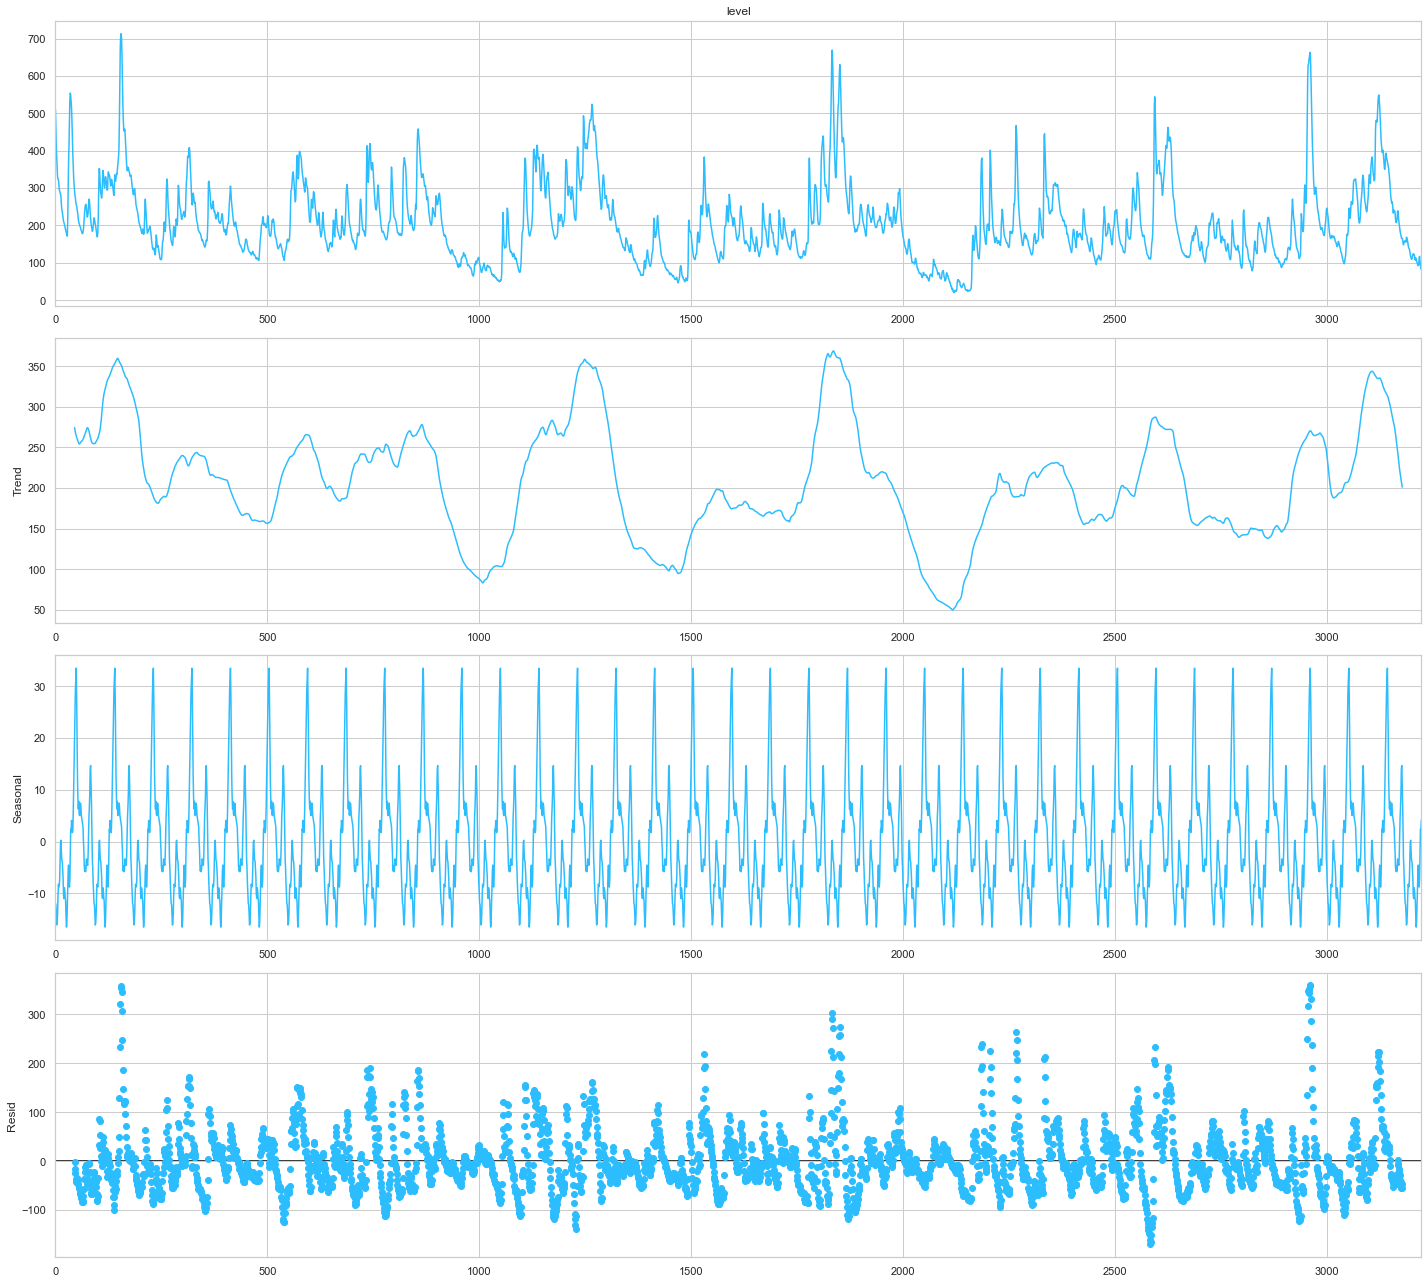

In [50]:
plt.rc("figure", figsize=(20,18))
result_add.plot()
plt.savefig(path + 'seasonality.png', dpi=300)
plt.show()

Show distribution of data by using a Box Plot. The Box shows the quartiles of the dataset, the whiskers show the rest of the distribution

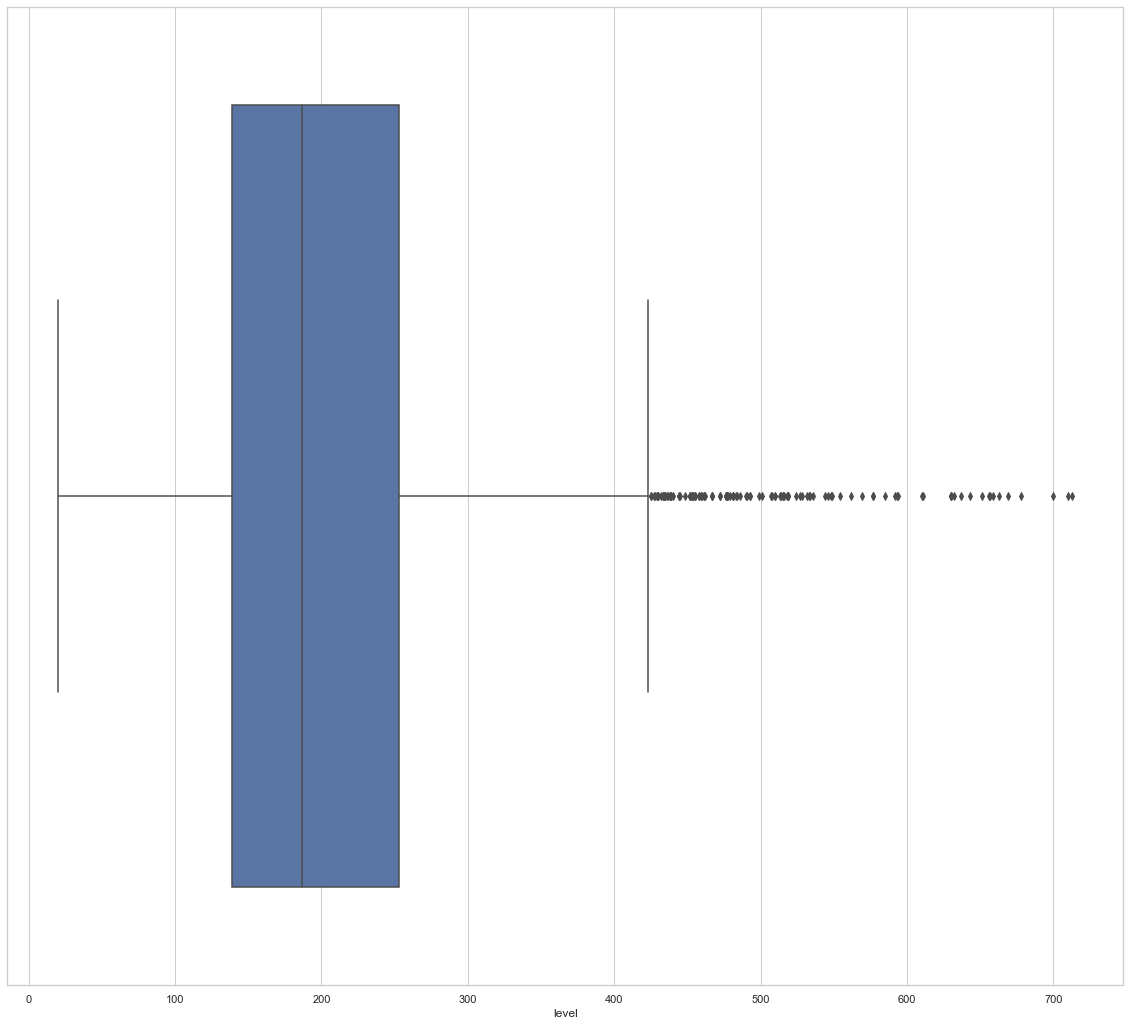

In [51]:
plt.figure(2)
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data['level'])
plt.savefig(path + 'box_plot.png', dpi=300)

The Box Plot shows, that while most of the time, the rhine water level is at around 120 to 250, the level sometimes rises thrice the size of the average. It also seems like there are only outliers at a higher water level, none at a lower level. 

Split data according to months in order to see the variation in water levels per month since intuitively, the month is of great concern when looking at water levels

In [52]:
def split_data_monthly(data):
    monthly_data = data.copy()
    monthly_data['month'] = pd.DatetimeIndex(data['date']).month_name()
    monthly_median = monthly_data.groupby('month').agg(
        {'level': np.median}).reset_index()
    monthly_mean = monthly_data.groupby('month').agg({'level': np.mean}).reset_index()
    return monthly_mean, monthly_median

monthly_mean, monthly_median = split_data_monthly(data)

Sorts the months in the right order for the plot later on

In [53]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

monthly_mean['month'] = pd.Categorical(monthly_mean['month'], categories=months, ordered=True)
monthly_median['month'] = pd.Categorical(monthly_median['month'], categories=months, ordered=True)

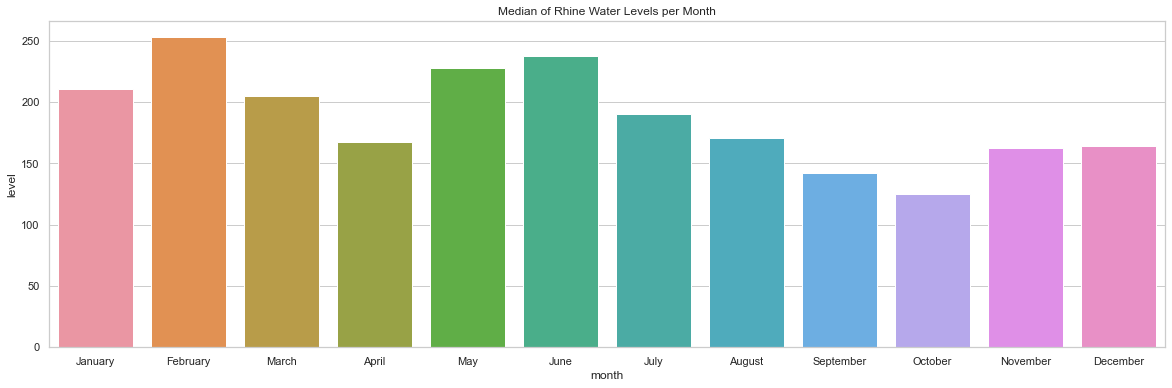

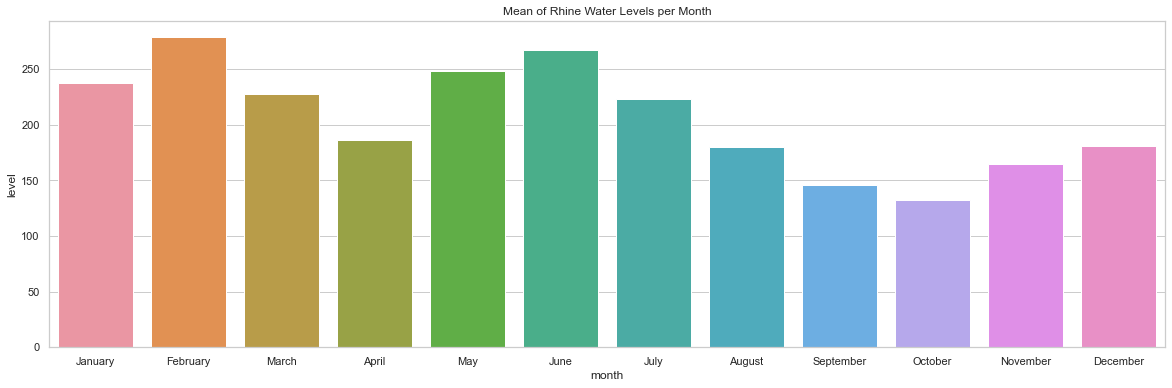

In [54]:
plt.figure(3, figsize=(20,6))
sns.barplot(x="month", y="level", data=monthly_median).set(title='Median of Rhine Water Levels per Month')
plt.savefig(path + 'median_month.png', dpi=300)
plt.figure(4, figsize=(20,6))
sns.barplot(x="month", y="level", data=monthly_mean).set(title='Mean of Rhine Water Levels per Month')
plt.savefig(path + 'mean_month.png', dpi=300)




The mean seems to be higher than the median in every month. To get a better view of this difference, the next bar plot plots the difference of the mean to the median each month

In [55]:
monthly_mean = monthly_mean.assign(diff_water_level = monthly_mean['level'] - monthly_median['level'])

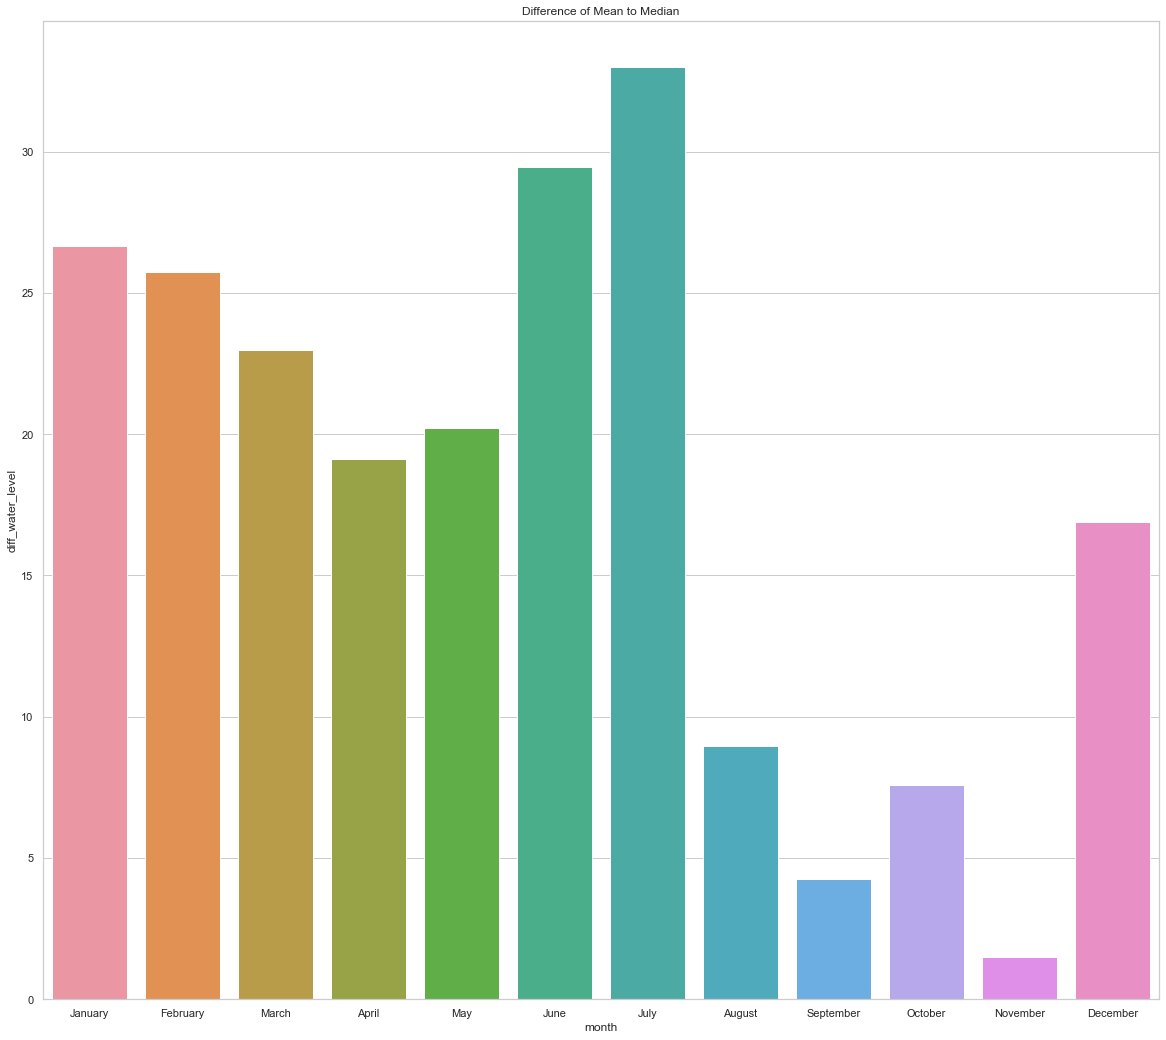

In [56]:
plt.figure(5)
sns.barplot(x='month', y='diff_water_level', data=monthly_mean).set(title='Difference of Mean to Median')
plt.savefig(path + 'difference_median_mean.png', dpi=300)


Now, one can see the differences of the median to the mean more clearly. In every month, mean > median, but more importantly, the difference varies by month, sometimes strongly. The chart suggests, that the there are less or less extreme outliers during august-november.

In [57]:
quantile1, quantile3 = data['level'].quantile([0.25, 0.75])
IQR = quantile3 - quantile1
lower = quantile1 - (1.5 * IQR)
upper = quantile3 + (1.5 * IQR)
outlier = []
outlier_upper = []
outlier_lower = []
for level in data['level']:
    if level < lower or level > upper:
        outlier.append(level)
    if level > upper:
        outlier_upper.append(level)
    if level < lower:
        outlier_lower.append(level)
print('There are {} outliers (:= outside of the 25% and 75% quantile) in the data from a total of {} data points. \nThat makes {}% of the data outliers'.format(
    len(outlier), len(data['level']), round(len(outlier) / len(data['level']) * 100, 3)))
print('Of these, there are {} smaller than the 25 percentile, and {} bigger than the 75 percentile'.format(len(outlier_lower), len(outlier_upper)))

There are 122 outliers (:= outside of the 25% and 75% quantile) in the data from a total of 3224 data points. 
That makes 3.784% of the data outliers
Of these, there are 0 smaller than the 25 percentile, and 122 bigger than the 75 percentile


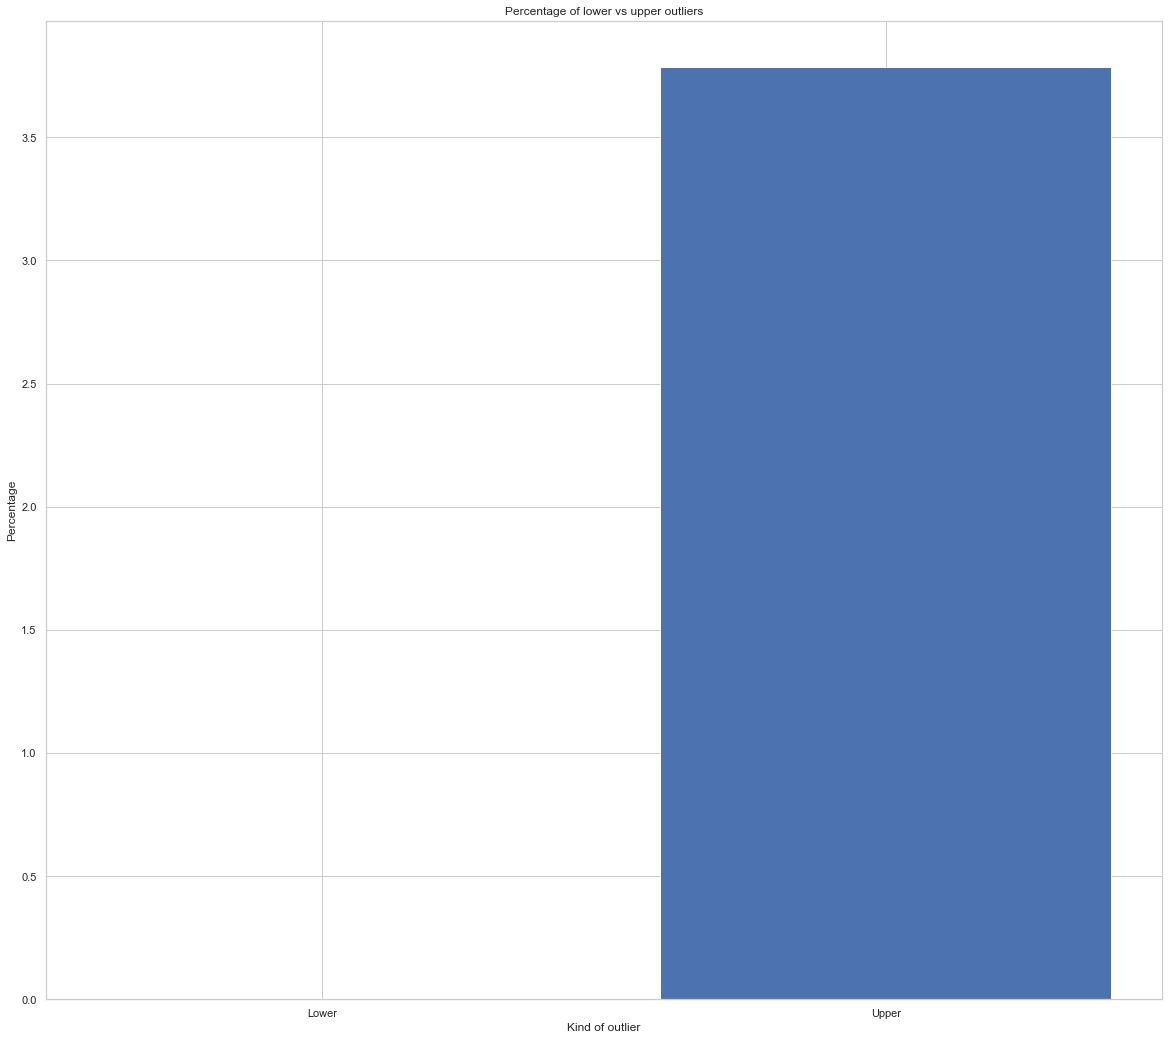

In [58]:
plt.figure(6)
plt.bar(np.arange(2), [len(outlier_lower), round(len(outlier) / len(data['level']) * 100, 3)])
plt.title('Percentage of lower vs upper outliers')
plt.xlabel('Kind of outlier')
plt.ylabel('Percentage')
plt.xticks(np.arange(2), ['Lower', 'Upper'])
plt.savefig(path + 'outliers.png', dpi=300)
